<a href="https://colab.research.google.com/github/JuanSpecht/ML2021/blob/main/TP3/ML_TP3_parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje de máquina: Trabajo práctico 3, parte 1

## Importo las bibliotecas necesarias

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

## Funciones a utilizar

In [13]:
def generate_datasets(mean, var11, var22, var12, n, cat):
    cov_matrix = [[var11, var12], [var12, var22]] # matriz de covarianza

    rng = np.random.default_rng(2021)
    x1, x2 = rng.multivariate_normal(mean, cov_matrix, n).T

    df = pd.DataFrame({'X1': x1, 'X2': x2, 'Clase': cat})

    return df

# Quizás debería separarla en partes que hagan cosas más específicas
def knn_scatter (df, neighbor_number, tsize):
    # ref: http://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_iris_knn.html
    cmap_background = ListedColormap(['#d2d9ec', '#f9e0d2'])
    cmap_data = ListedColormap(['#4e65b2', '#e78047'])

    data = df.iloc[:,[0,1]]
    df.Clase = pd.Categorical(df.Clase)
    df['Code'] = df.Clase.cat.codes

    labels = df['Code'].values
    x_train, x_test, y_train, y_test = train_test_split(data, 
                                                        labels, 
                                                        test_size=tsize, 
                                                        random_state=1
                                                        )

    knn = neighbors.KNeighborsClassifier(n_neighbors=neighbor_number)
    knn.fit(x_train, y_train)

    x1_min, x1_max = df.X1.values.min() - .1, df.X1.values.max() + .1
    x2_min, x2_max = df.X2.values.min() - .1, df.X2.values.max() + .1
    
    x1x1, x2x2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                            np.linspace(x2_min, x2_max, 100))
    Z = knn.predict(np.c_[x1x1.ravel(), x2x2.ravel()])

    Z = Z.reshape(x1x1.shape)
    plt.figure(figsize=(5,5))
    plt.pcolormesh(x1x1, x2x2, Z, cmap=cmap_background)

    plt.scatter(df.X1, df.X2, c=df['Code'], 
                cmap=cmap_data, edgecolors=(1,1,1,0.8)
                )
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.axis('tight')

# Para graficar precisión, exactitud, f-measure e índice de jaccard en función de k
def plot_params(df):
    data = df.iloc[:,[0,1]]
    df.Clase = pd.Categorical(df.Clase)
    df['Code'] = df.Clase.cat.codes

    labels = df['Code'].values
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=1 )

    k_vec = np.arange(1,51,1)

    # Creo vectores vacíos para los elementos de la matriz de confusión
    tn = np.empty_like(k_vec)
    fp = np.empty_like(k_vec)
    fn = np.empty_like(k_vec)
    tp = np.empty_like(k_vec)

    # Calculo la matriz de confusión como función de k
    for k in k_vec:
        # Entreno el modelo para cada valor de k
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        # Obtengo la matriz de confusión
        y_true = y_test
        y_pred = knn.predict(x_test)
        tn[k-1], fp[k-1], fn[k-1], tp[k-1] = confusion_matrix(y_true, y_pred).ravel()

    # Defino los parámetros estadisticos
    p = np.sum(y_test) # Cantidad de positivos (clase B) en el grupo de testeo
    n = len(y_test) - p # Cantidad de negativos (clase A) en el grupo de testeo
    pp = np.sum(y_pred) # Predichos positivos (clase B)
    precision = tp/pp
    accuracy = (tp + tn) / (p + n)
    f_measure = 2*tp / (2*tp + fp + fn)
    jaccard = tp / (tp + fn + fp)
    bias = ((tp+fn)/(tn+fp))/((tp+fp)+(tn+fn))
    fdr = fp/(tp+fp)

    fig, ax = plt.subplots(6, sharex=True, figsize=(8,8))

    ax[0].plot(k_vec,precision)
    ax[1].plot(k_vec,accuracy)
    ax[2].plot(k_vec,f_measure)
    ax[3].plot(k_vec,jaccard)
    ax[4].plot(k_vec,bias)
    ax[5].plot(k_vec,fdr)

    ax[0].set_ylabel('Precisión')
    ax[1].set_ylabel('Exactitud')
    ax[2].set_ylabel('F-measure')
    ax[3].set_ylabel('Ind. de Jaccard')
    ax[4].set_ylabel('Sesgo')
    ax[5].set_ylabel('FDR')
    plt.xlabel("k")
    

    plt.axis('tight')

# para hacer un scatter interactivo con k y N como variables
def interactive_scatter(df):
    widgets.interact(knn_scatter,
                     df = widgets.fixed(df),
                     neighbor_number = widgets.IntSlider(
                         value=10,
                         min=1,
                         max=50,
                         step=1,
                         description='K:',
                         orientation='horizontal'
                         ),
                     tsize = widgets.FloatSlider(
                         value=0.5,
                         min=0.1,
                         max=0.5,
                         step=0.05,
                         description='N:',
                         orientation='horizontal'
                         )
                     )

## Genero el dataset y lo visualizo

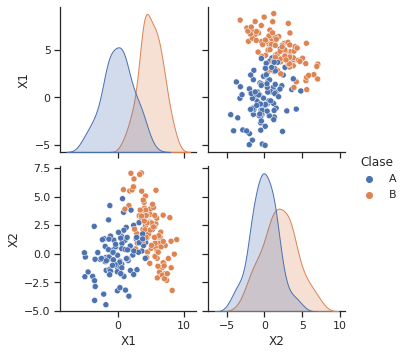

In [4]:
# genero los datasets "A" y "B"
df_a = generate_datasets([0, 0], 6, 3, 1.5, 100, 'A')
df_b = generate_datasets([5, 2], 3, 6, -3, 100, 'B')

# Concateno y randomizo los datasets
df_ab = pd.concat([df_a, df_b])
df_shuffled = df_ab.sample(frac=1).reset_index(drop=True)

sns.set_theme(style="ticks")
sns.pairplot(df_shuffled, hue="Clase")

#HACÉ QUE PLOTEE UNA TABLITA CON LOS DATOS BÁSICOS DE LA DATA.


## Gráfico interactivo con K (número de vecinos) y N (cantidad de datos para testeo) como variables

In [5]:
interactive_scatter(df_shuffled)

interactive(children=(IntSlider(value=10, description='K:', max=50, min=1), FloatSlider(value=0.5, description…

## Observaciones 

* Para el caso k = 10 y un split de 50% / 50% entre entrenamiento y testeo, hay muchos datos de la clase "A" identificados como "B". Esto puede deberse a que la varianza del grupo de datos "B" es menor que la del grupo "A" en la dirección de la recta que une ambos centroides. Por este motivo, los datos "A" que están dentro de la nube "B" terminan tienen más vecinos "B" que "A".
* Si se incrementa el valor de k se ve que crece el número de datos "A" identificados como "B" (en el gráfico se retrae la mancha "A" en favor de la "B"). Lo contrario sucede si disminuímos el valor de k

## Obtengo la matriz de confusión y calculo diferentes parámetros estadísticos en función de k para elegir un k óptimo según algún criterio (split de 50% / 50%)

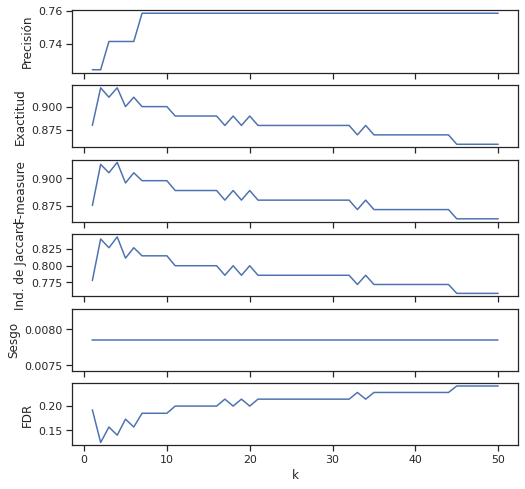

In [14]:
plot_params(df_shuffled)


Se ve que para un amplio rango de valores de k se maximizan al mismo tiempo la precisión, exactitud, f-measure y el índice de Jaccard, por lo que alguno de estos valores de k pueden ser una buena elección para el clasificador.

Por otro lado también se aprecia que los valores de los cuatro parámetros varían muy poco, con lo cual no parecen ser tan determinantes para elegir el valor de k. Habría que tener en cuenta cosas como el sesgo y la variancia (págs 8 y 9 ppt de Claudio)

Para valores altos de k los parámetros no son

## Cambiando el centroide y la variancia:
### Acerco los centroides manteniendo las varianzas

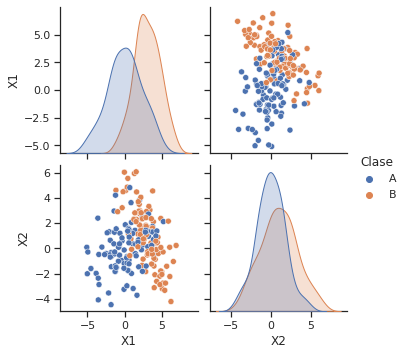

In [7]:
# genero los datasets "A" y "B"
df_a_2 = generate_datasets([0, 0], 6, 3, 1.5, 100, 'A')
df_b_2 = generate_datasets([3, 1], 3, 6, -3, 100, 'B')

# Concateno y randomizo los datasets
df_ab_2 = pd.concat([df_a_2, df_b_2])
df_shuffled_2 = df_ab_2.sample(frac=1).reset_index(drop=True)

sns.set_theme(style="ticks")
sns.pairplot(df_shuffled_2, hue="Clase")

* Se puede ver que alejando el centroide de las clases y/o disminuyendo su variancia el clasificador mejora su calidad
* Quizás pueda hacer alguna observación sobre que no es necesario usar un k tan grande, o un grupo de entreamiento tan grande y entonces es más económico computacionalmente, fijate en el video de la clase qué dice Claudio
* Pongo: por ejemplo, con k = tanto, N= tanto pasa tal cosa. Así con dos o tres ejemplos

In [8]:
interactive_scatter(df_shuffled_2)

interactive(children=(IntSlider(value=10, description='K:', max=50, min=1), FloatSlider(value=0.5, description…

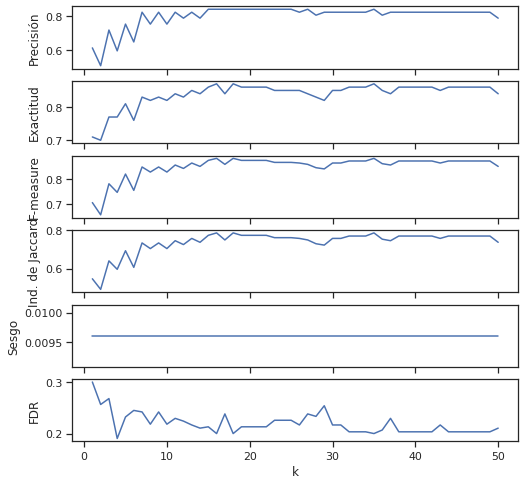

In [15]:
plot_params(df_shuffled_2)

Los valores de todos ls parámetros son más bajos para este dataset dado que los centroides están más cerca y el clasificador no es capaz de asignar adecuadamente las categorías

## Modifico las matrices de covarianza

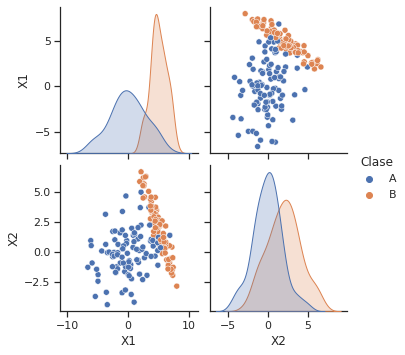

In [10]:
# genero los datasets "A" y "B"
df_a_3 = generate_datasets([0, 0], 10, 3, 1.5, 100, 'A')
df_b_3 = generate_datasets([5, 2], 2, 5, -3, 100, 'B')

# Concateno y randomizo los datasets
df_ab_3 = pd.concat([df_a_3, df_b_3])
df_shuffled_3 = df_ab_3.sample(frac=1).reset_index(drop=True)

sns.set_theme(style="ticks")
sns.pairplot(df_shuffled_3, hue="Clase")

In [11]:
interactive_scatter(df_shuffled_3)

interactive(children=(IntSlider(value=10, description='K:', max=50, min=1), FloatSlider(value=0.5, description…

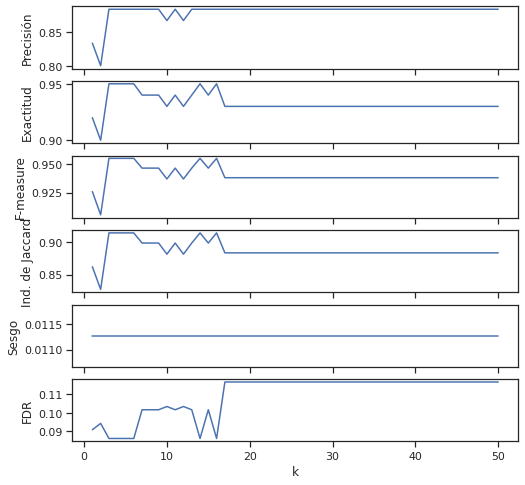

In [16]:
plot_params(df_shuffled_3)